## Agentic DR-Learning (Tennis)
### 1. Imports

In [1]:
import numpy as np
import torch

from unityagents import UnityEnvironment
from collections import deque

from ddpg_agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Starting the enviroment

In [2]:
env = UnityEnvironment(file_name="Tennis")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Mono path[0] = '/Users/gerritdolderer/AI/learn/DRL/deep-reinforcement-learning-master/p3_collab-compet/Tennis.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/gerritdolderer/AI/learn/DRL/deep-reinforcement-learning-master/p3_collab-compet/Tennis.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Config Class to test different hyperparameters

In [3]:
class Config:
    def __init__(self, description, buffer_size=int(1e5), batch_size=64, gamma=0.99, tau=1e-3, lr_actor=0.0001, lr_critic=0.001, fc1=128, fc2=128, seed=0):
        self.description = description
        self.BUFFER_SIZE = buffer_size
        self.BATCH_SIZE = batch_size
        self.GAMMA = gamma
        self.TAU = tau
        self.LR_ACTOR = lr_actor
        self.LR_CRITIC = lr_critic
        self.fc1 = fc1
        self.fc2 = fc2
        self.SEED = seed

configs_batch = [
    Config(description="Default Configuration | BATCH_SIZE=32"),
    Config(description="BATCH_SIZE=64", batch_size=64),
    Config(description="BATCH_SIZE=128", batch_size=128),
]

configs_buffer = [
    Config(description="Default Configuration | BUFFER_SIZE=100,000"),
    Config(description="BUFFER_SIZE=1,000", buffer_size=1000),
    Config(description="BUFFER_SIZE=10,000", buffer_size=10000),
    Config(description="BUFFER_SIZE=500,000", buffer_size=500000),
]

configs = [
    Config(description="Default Configuration"),
    Config(description="Gamma: 0.95", gamma=0.95),
    Config(description="Lower TAU: 0.0001", tau=0.0001),
    Config(description="Higher TAU: 0.1", tau=0.1),
    Config(description="High TAU with High LRs | Critic: 0.01, Actor: 0.001, TAU: 0.1", lr_actor=0.001, lr_critic=0.01, tau=0.1),
    Config(description="Lower LRs | Critic: 0.0001, Actor: 0.00001", lr_actor=0.00001, lr_critic=0.0001),
    Config(description="Low LRs with High TAU | Critic: 0.00001, Actor: 0.00001, TAU: 0.1", lr_actor=0.00001, lr_critic=0.00001, tau=0.1),
    Config(description="Low LRs with High Gamma | Critic: 0.00001, Actor: 0.00001, Gamma: 0.995", lr_actor=0.00001, lr_critic=0.00001, gamma=0.995),
    Config(description="Super low LRs | Critic: 0.00005, Actor: 0.000005", lr_actor=0.000005, lr_critic=0.00005),
    Config(description="Higher LRs | Critic: 0.01, Actor: 0.001", lr_actor=0.001, lr_critic=0.01),
    Config(description="Higher LRs | Critic: 0.001, Actor: 0.001", lr_actor=0.001, lr_critic=0.001),
    Config(description="Higher LRs | Critic: 0.0001, Actor: 0.0001", lr_actor=0.0001, lr_critic=0.0001),
    Config(description="Increased Hidden Units | fc1: 256, fc2: 128", fc1=256, fc2=128),
    Config(description="Even more Hidden Units | fc1: 512, fc2: 256", fc1=512, fc2=256),
    Config(description="More Hidden Units, lower LRs | fc1: 256, fc2: 128, Critic: 0.0001, Actor: 0.00001", fc1=256, fc2=128, lr_actor=0.00001, lr_critic=0.0001),
    Config(description="More Hidden Units, lower LRs, even lower batch size (16) | fc1: 256, fc2: 128, Critic: 0.0001, Actor: 0.00001, BATCH_SIZE: 16", fc1=256, fc2=128, lr_actor=0.00001, lr_critic=0.0001, batch_size=16),
    Config(description="More Hidden Units, super high gamma (0.995), low batch size | fc1: 256, fc2: 128, Gamma: 0.995, BATCH_SIZE: 16", fc1=256, fc2=128, gamma=0.995, batch_size=16),
    Config(description="Less Hidden Units | fc1: 64, fc2: 64", fc1=64, fc2=64),
    Config(description="Less Hidden Units, higher LRs | fc1: 64, fc2: 64, Critic: 0.01, Actor: 0.001", fc1=64, fc2=64, lr_actor=0.001, lr_critic=0.01),
    Config(description="Less Hidden Units, lower Gamma: 0.95 | fc1: 64, fc2: 64, Gamma: 0.95", fc1=64, fc2=64, gamma=0.95),
    Config(description="Less Hidden Units, lower TAU | fc1: 64, fc2: 64, TAU: 0.0001", fc1=64, fc2=64, tau=0.0001),
]


## Training Function

In [4]:
def ddpg(config, n_episodes=10000, max_t=1000, solve_condition=0.5):
    scores = []
    avg_score_list = []
    scores_deque = deque(maxlen=100)
    agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, config=config)
    solved = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards
            if np.any(dones):
                break 
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        avg_score = np.mean(scores_deque)
        avg_score_list.append(avg_score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.3f}'.format(i_episode, avg_score, np.mean(score)), end="")
        
        if avg_score > solve_condition and not solved:
            print('\nEnvironment solved in {:d} episodes!'.format(i_episode))
            solved = True

    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

    return scores, avg_score_list


## Different tests to finetune the hyperparameters

### 1. Batch size


Running configuration 1/3: Default Configuration | BATCH_SIZE=32
Episode 1200	Average Score: 0.10	Score: 0.0455
Running configuration 2/3: BATCH_SIZE=64
Episode 1200	Average Score: 0.05	Score: -0.005
Running configuration 3/3: BATCH_SIZE=128
Episode 1200	Average Score: 0.19	Score: 0.2455

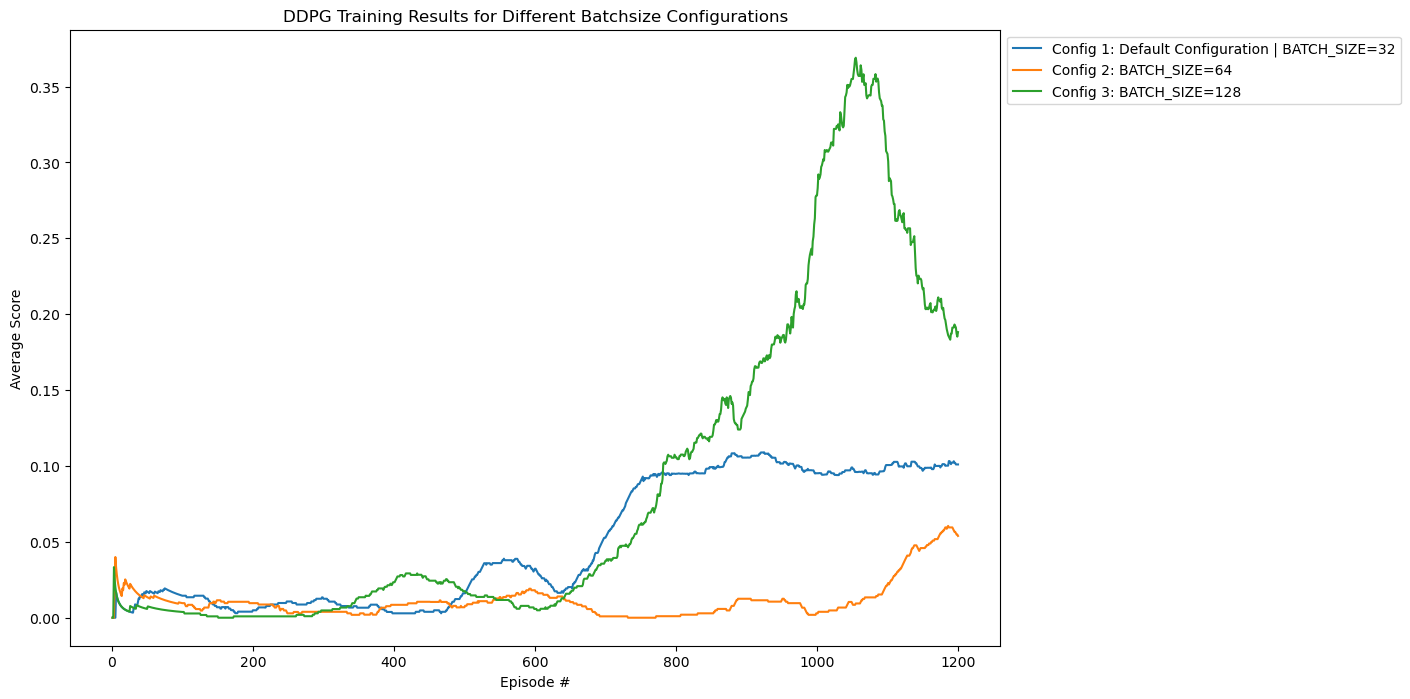

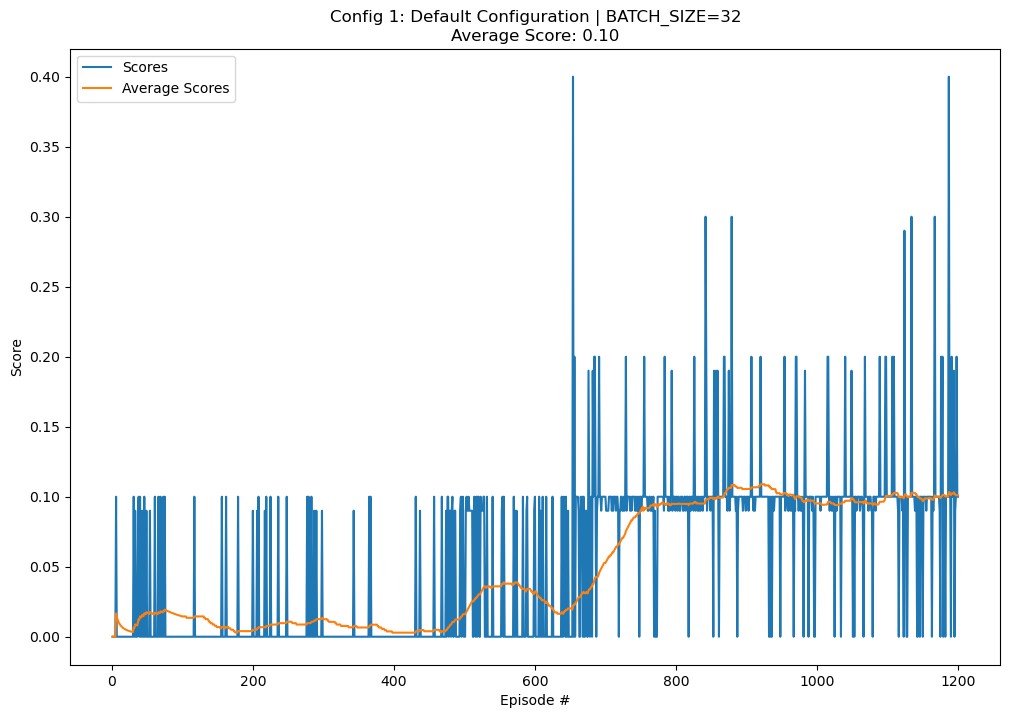

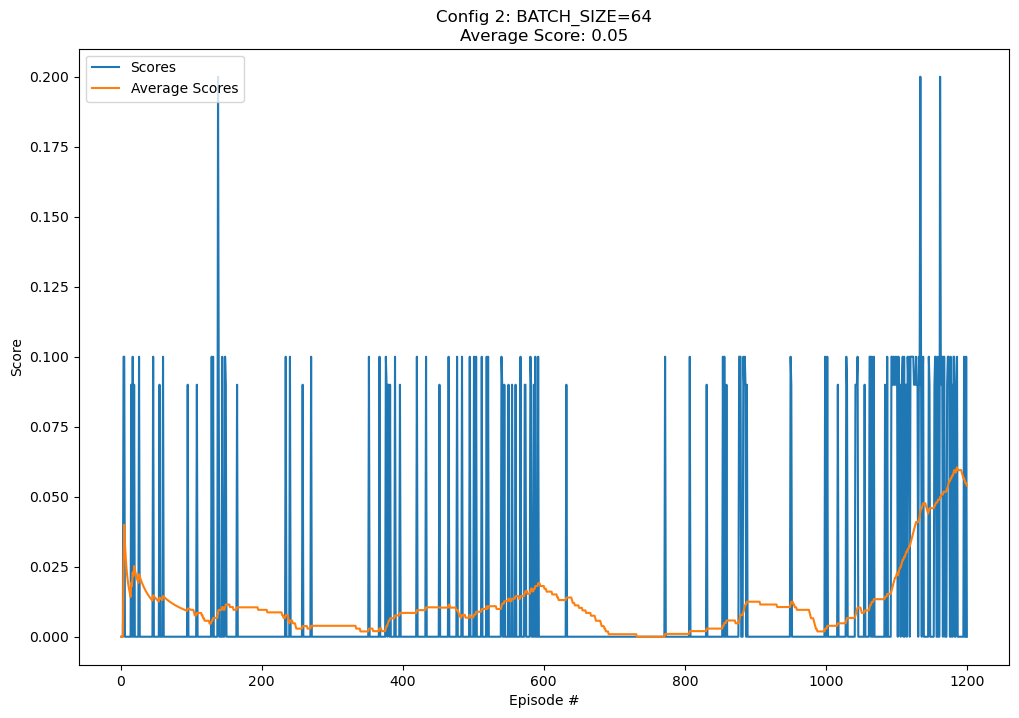

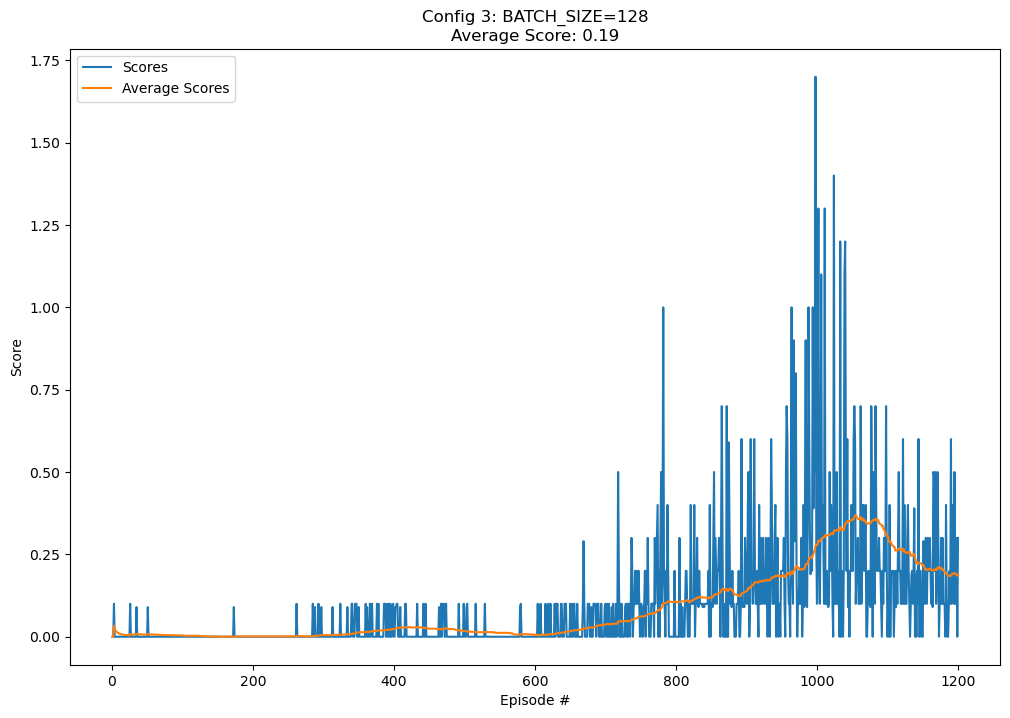

In [5]:
results = []

for idx, config in enumerate(configs_batch):
    print(f"\nRunning configuration {idx + 1}/{len(configs_batch)}: {config.description}")
    scores, avg_score_list = ddpg(config,n_episodes=1200)
    results.append((config, scores, avg_score_list))

fig, ax = plt.subplots(figsize=(12, 8))

for idx, (config, _, avg_scores) in enumerate(results):
    ax.plot(np.arange(1, len(avg_scores) + 1), avg_scores, label=f"Config {idx + 1}: {config.description}")

ax.set_ylabel('Average Score')
ax.set_xlabel('Episode #')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('DDPG Training Results for Different Batchsize Configurations')
plt.show()

for idx, (config, scores, avg_scores) in enumerate(results):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(np.arange(1, len(scores) + 1), scores, label='Scores')
    ax.plot(np.arange(1, len(avg_scores) + 1), avg_scores, label='Average Scores')
    ax.set_ylabel('Score')
    ax.set_xlabel('Episode #')
    ax.legend(loc='upper left')
    plt.title(f"Config {idx + 1}: {config.description}\nAverage Score: {avg_scores[-1]:.2f}")
    plt.show()

### 2. Buffer size


Running configuration 1/4: Default Configuration | BUFFER_SIZE=100,000
Episode 1200	Average Score: 0.12	Score: 0.0455
Running configuration 2/4: BUFFER_SIZE=1,000
Episode 1200	Average Score: 0.00	Score: -0.005
Running configuration 3/4: BUFFER_SIZE=10,000
Episode 1200	Average Score: 0.00	Score: -0.005
Running configuration 4/4: BUFFER_SIZE=500,000
Episode 1200	Average Score: 0.00	Score: -0.005

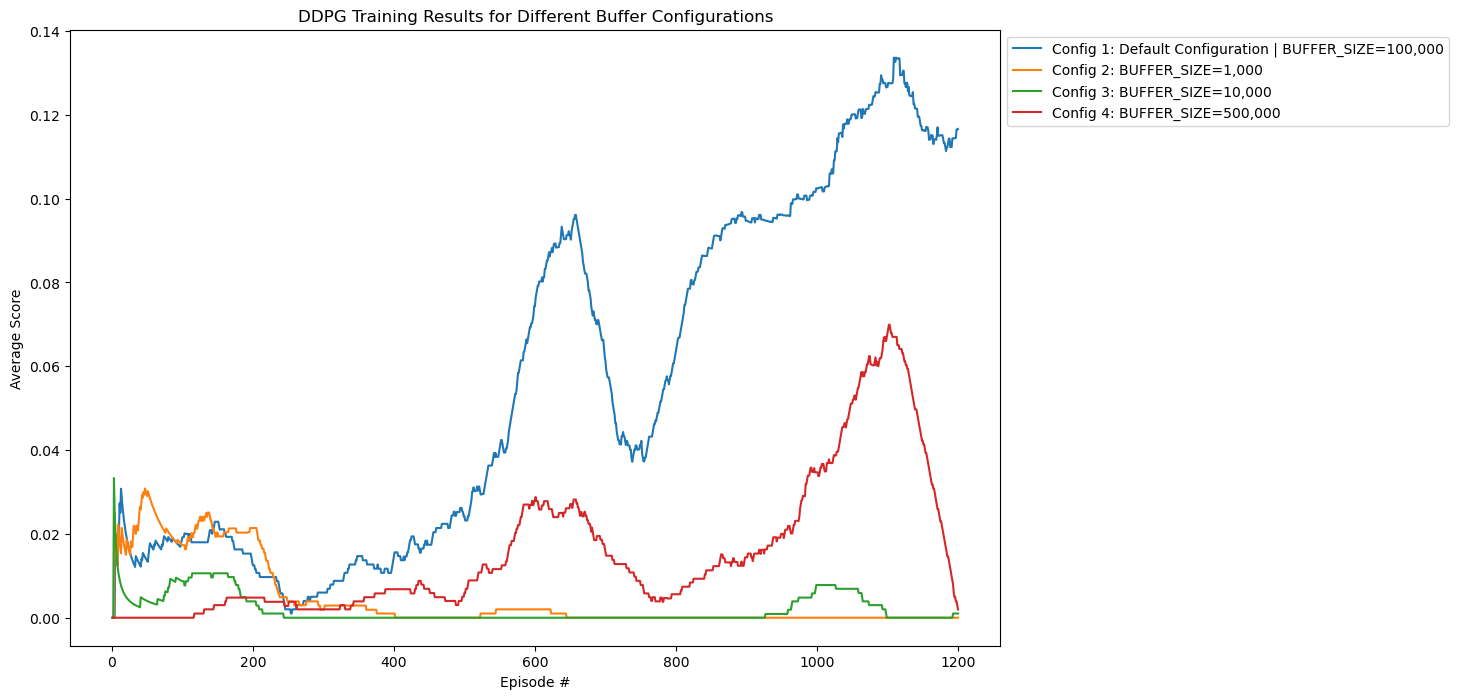

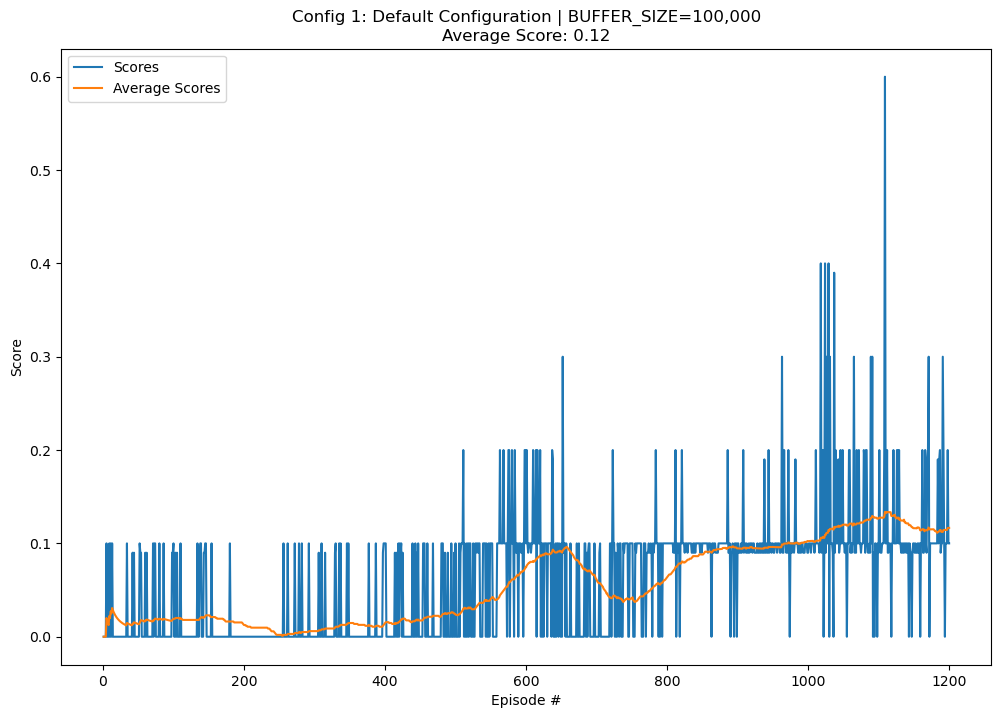

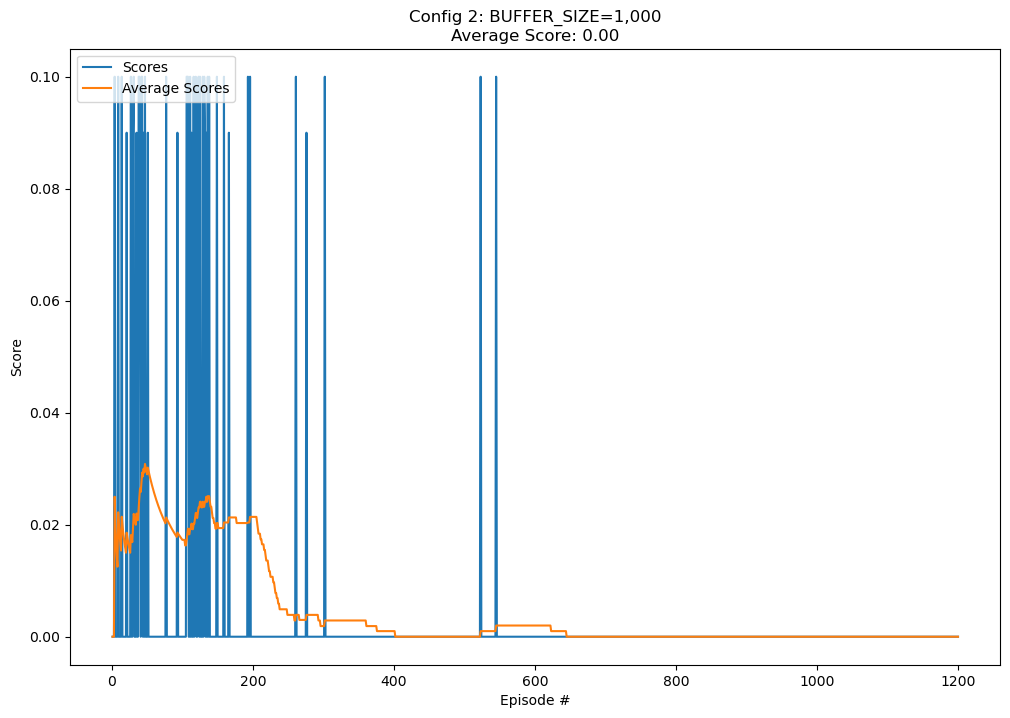

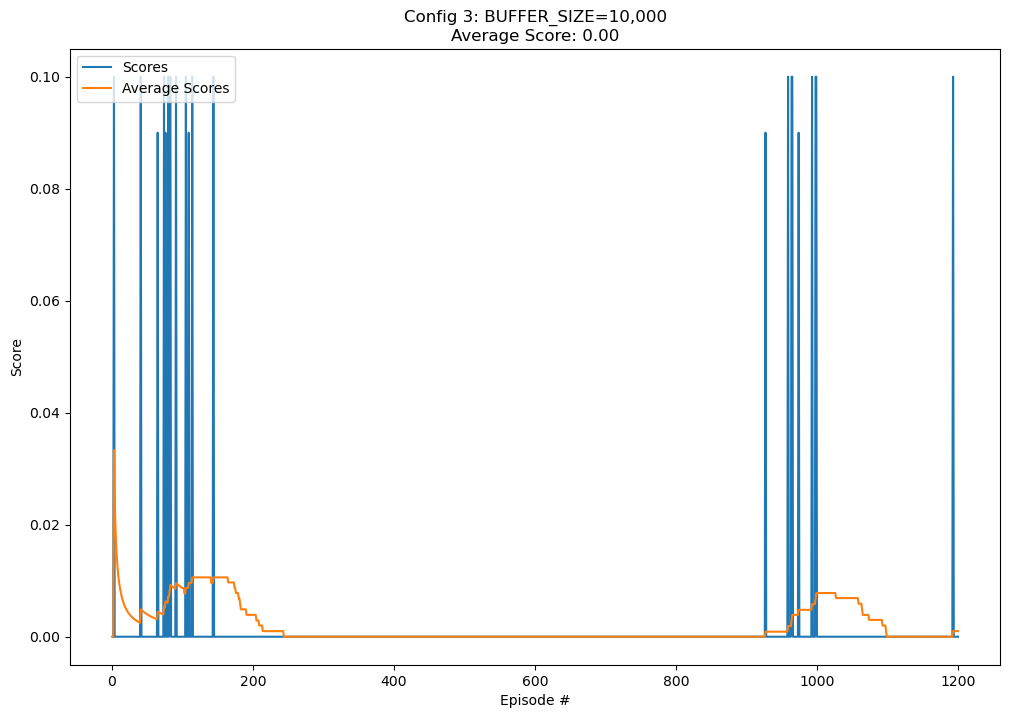

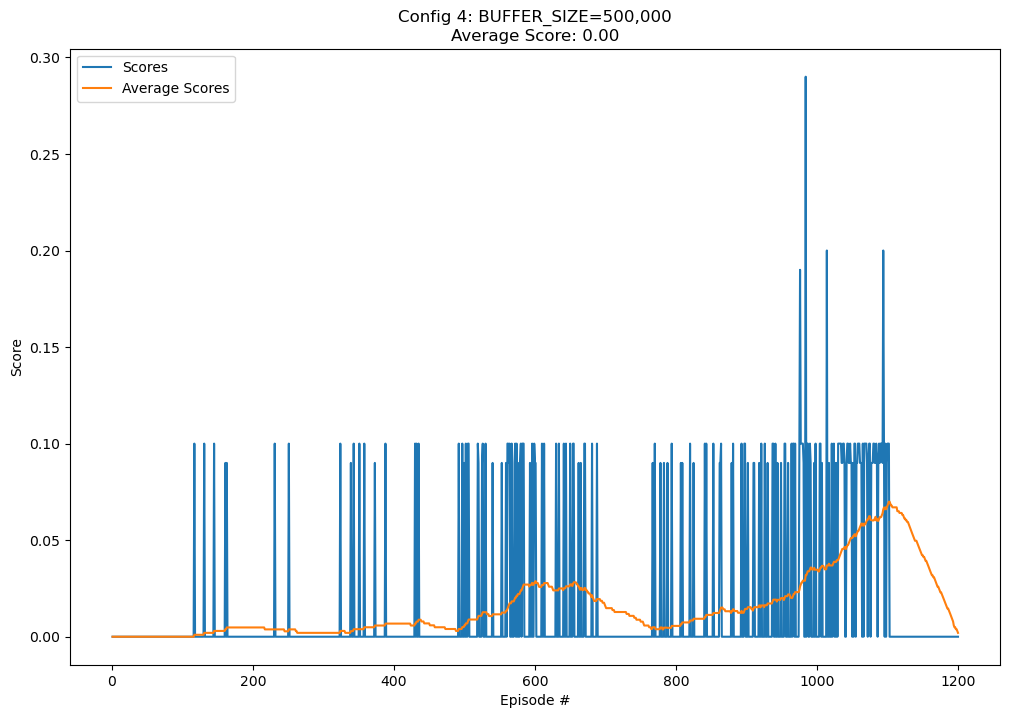

In [6]:
results = []

for idx, config in enumerate(configs_buffer):
    print(f"\nRunning configuration {idx + 1}/{len(configs_buffer)}: {config.description}")
    scores, avg_score_list = ddpg(config,n_episodes=1200)
    results.append((config, scores, avg_score_list))

fig, ax = plt.subplots(figsize=(12, 8))

for idx, (config, _, avg_scores) in enumerate(results):
    ax.plot(np.arange(1, len(avg_scores) + 1), avg_scores, label=f"Config {idx + 1}: {config.description}")

ax.set_ylabel('Average Score')
ax.set_xlabel('Episode #')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('DDPG Training Results for Different Buffer Configurations')
plt.show()

for idx, (config, scores, avg_scores) in enumerate(results):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(np.arange(1, len(scores) + 1), scores, label='Scores')
    ax.plot(np.arange(1, len(avg_scores) + 1), avg_scores, label='Average Scores')
    ax.set_ylabel('Score')
    ax.set_xlabel('Episode #')
    ax.legend(loc='upper left')
    plt.title(f"Config {idx + 1}: {config.description}\nAverage Score: {avg_scores[-1]:.2f}")
    plt.show()

### 3. Learningrate, Gamma, Model Size


Running configuration 1/21: Default Configuration
Episode 1200	Average Score: 0.30	Score: 0.1455
Running configuration 2/21: Gamma: 0.95
Episode 1200	Average Score: 0.11	Score: 0.0455
Running configuration 3/21: Lower TAU: 0.0001
Episode 1200	Average Score: 0.02	Score: -0.005
Running configuration 4/21: Higher TAU: 0.1
Episode 1040	Average Score: 0.51	Score: 1.1955
Environment solved in 1040 episodes!
Episode 1200	Average Score: 0.48	Score: 0.2955
Running configuration 5/21: High TAU with High LRs | Critic: 0.01, Actor: 0.001, TAU: 0.1
Episode 1200	Average Score: 0.03	Score: -0.005
Running configuration 6/21: Lower LRs | Critic: 0.0001, Actor: 0.00001
Episode 1200	Average Score: 0.03	Score: -0.005
Running configuration 7/21: Low LRs with High TAU | Critic: 0.00001, Actor: 0.00001, TAU: 0.1
Episode 1200	Average Score: 0.02	Score: -0.005
Running configuration 8/21: Low LRs with High Gamma | Critic: 0.00001, Actor: 0.00001, Gamma: 0.995
Episode 1200	Average Score: 0.04	Score: -0.005
Runn

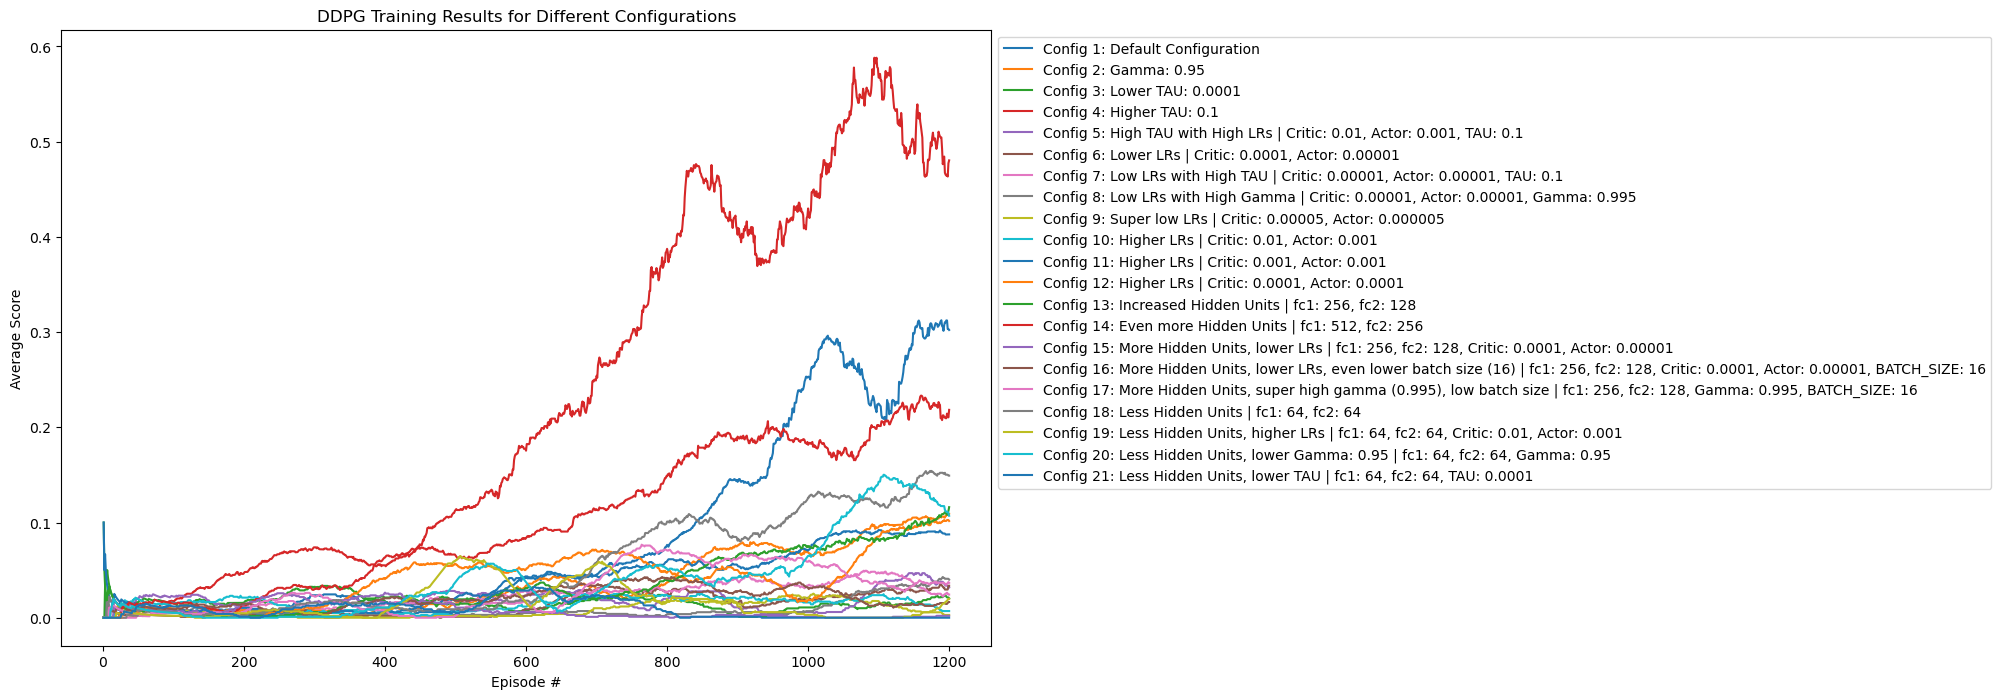

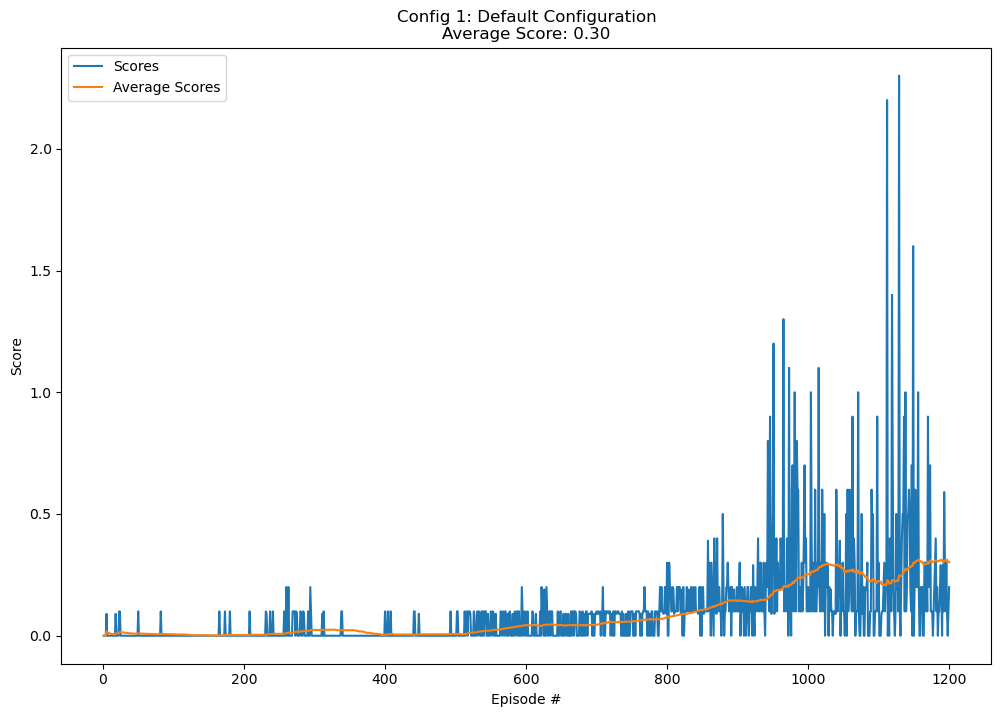

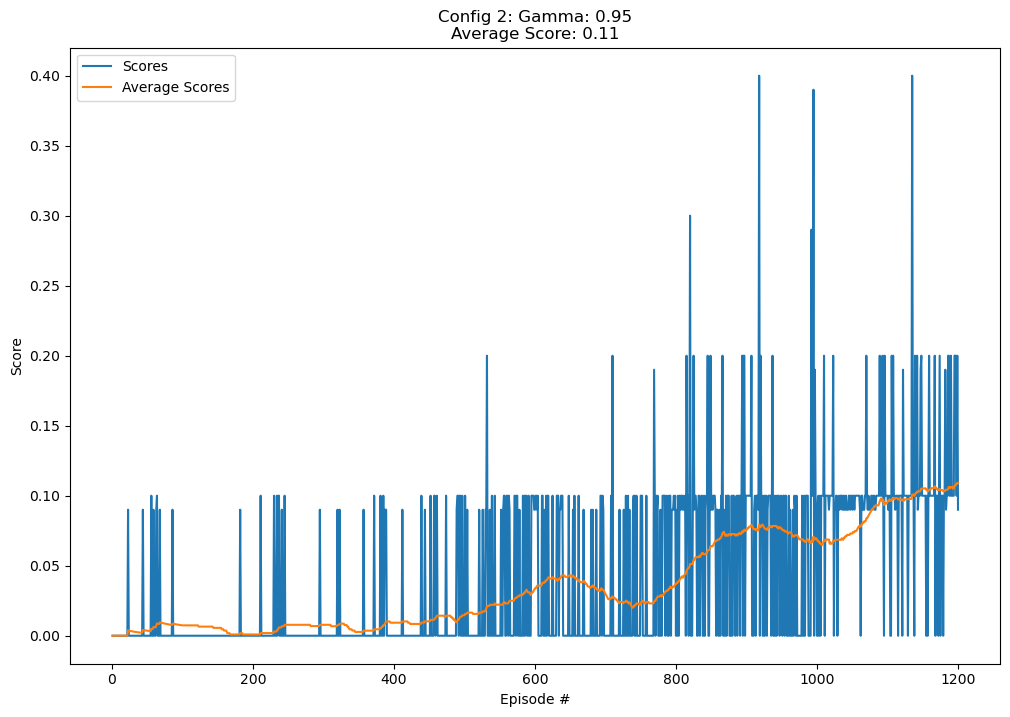

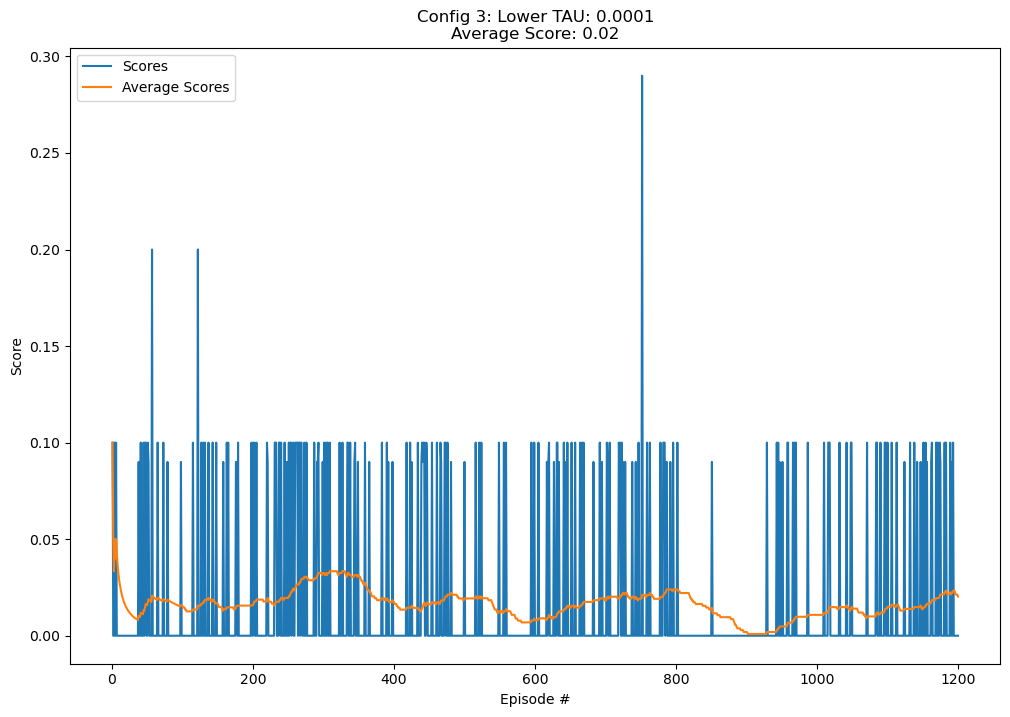

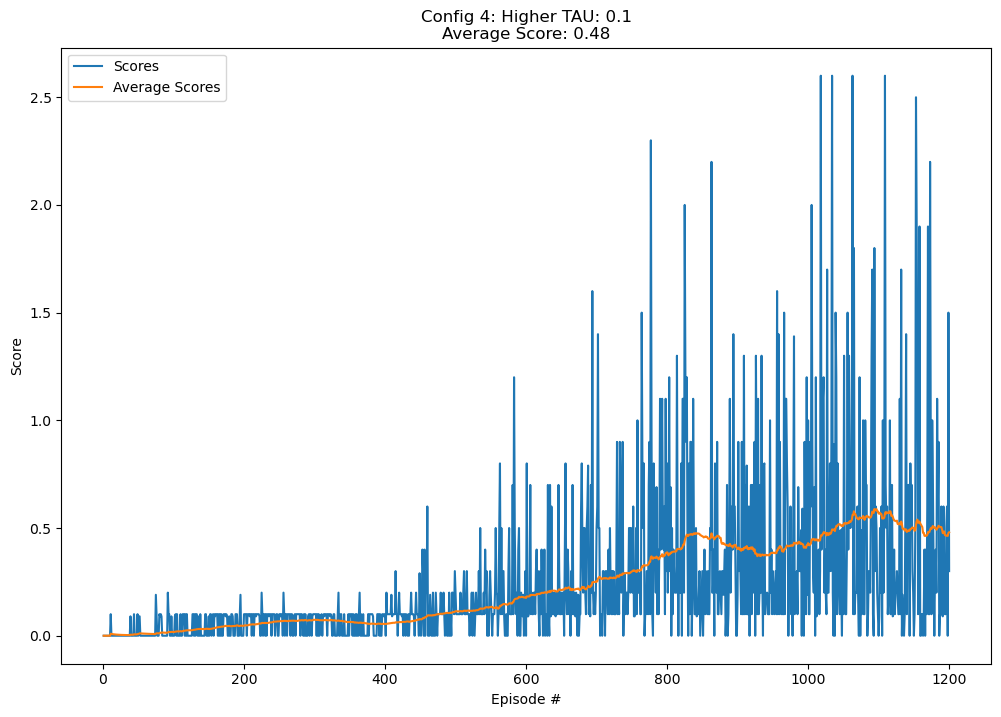

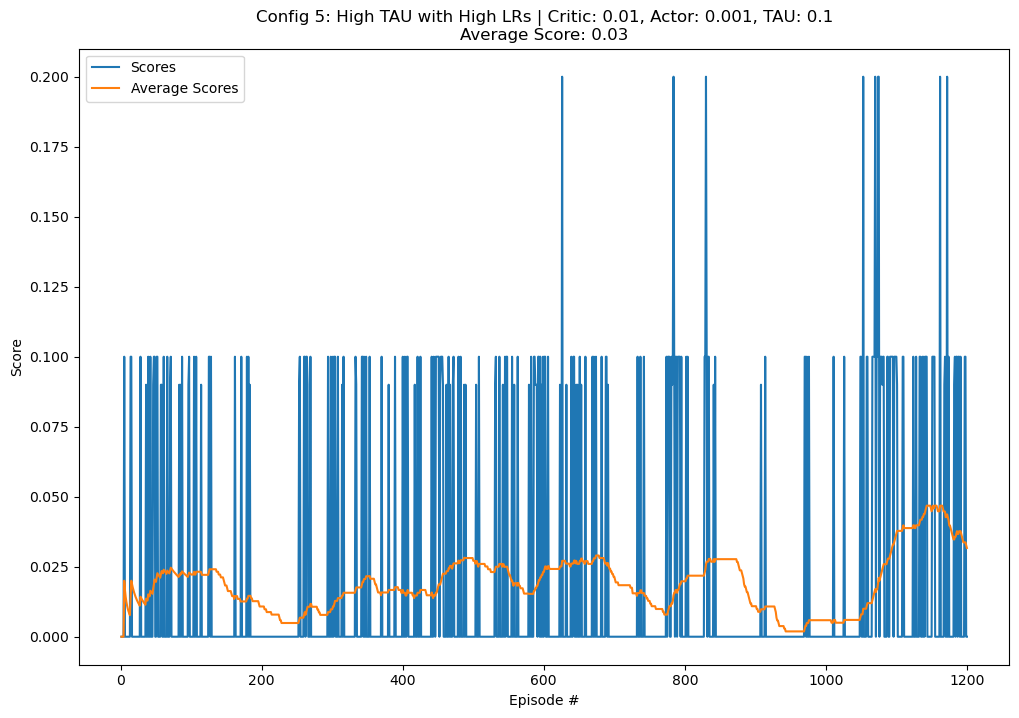

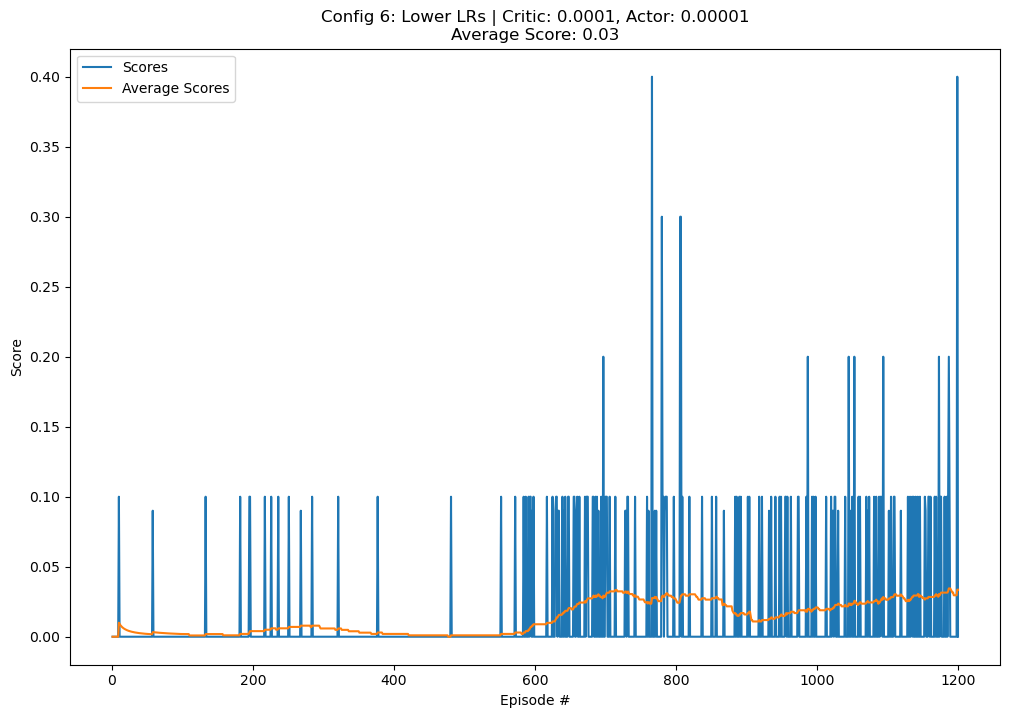

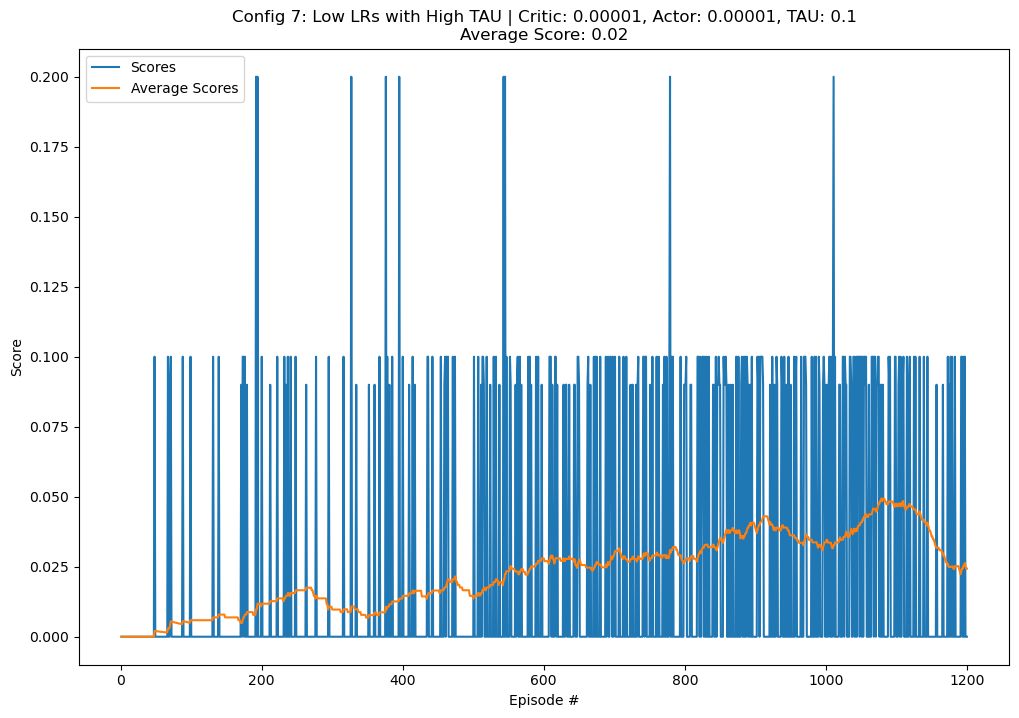

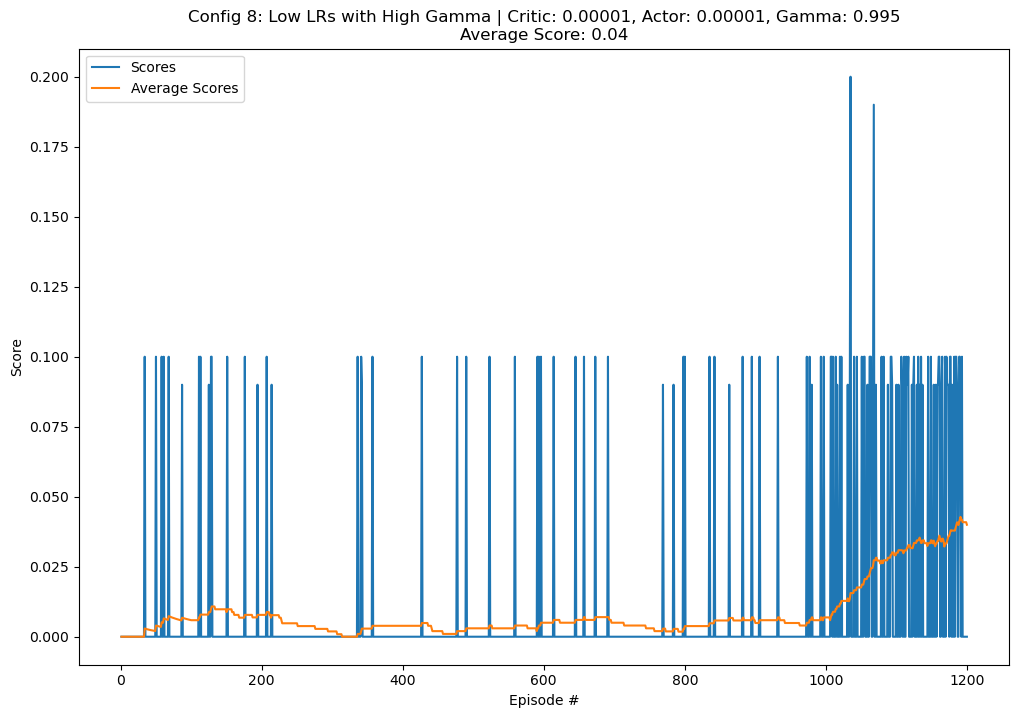

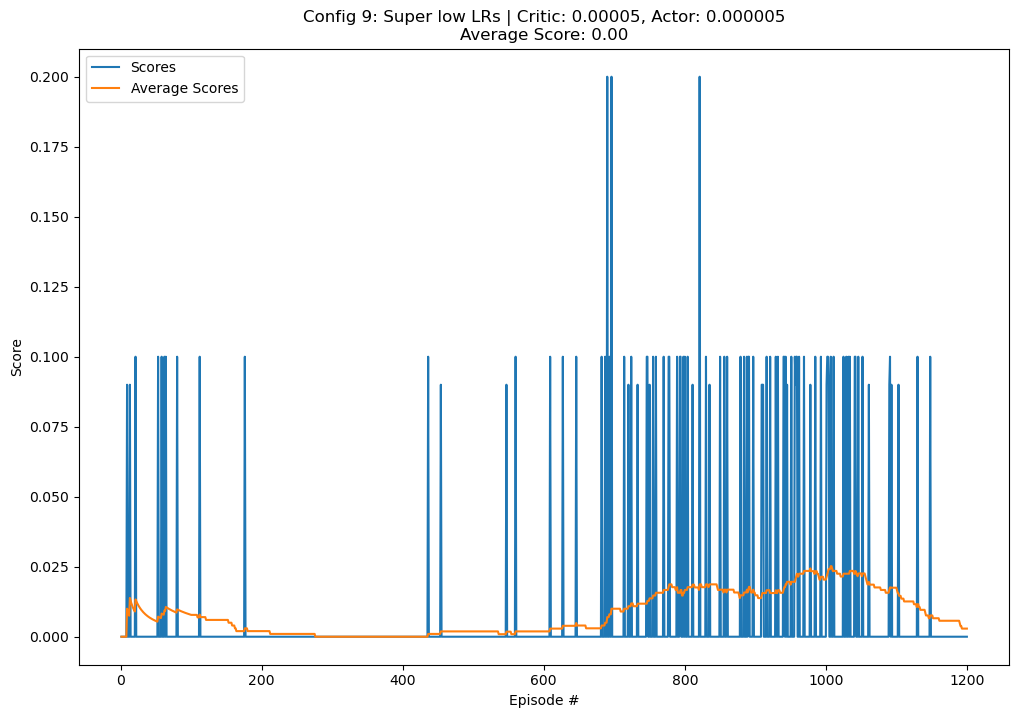

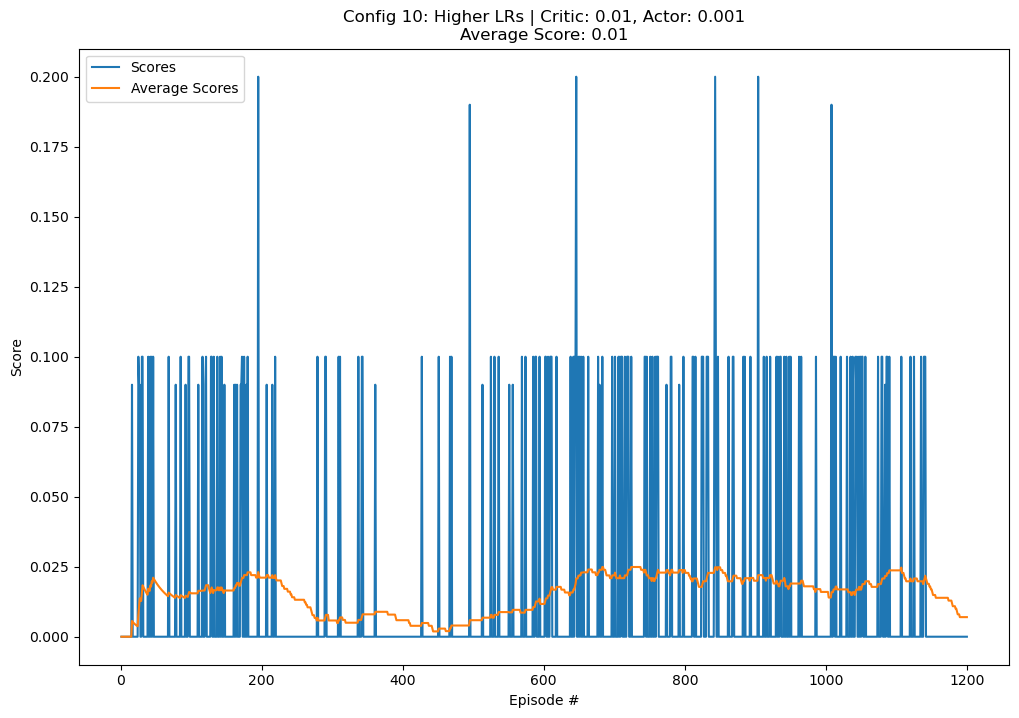

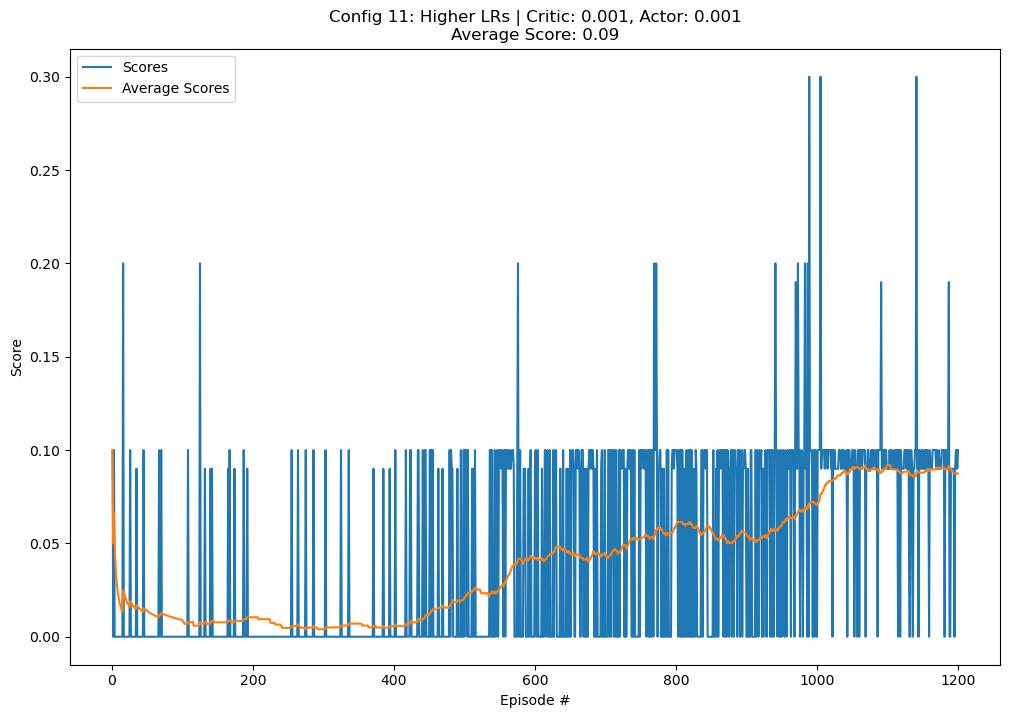

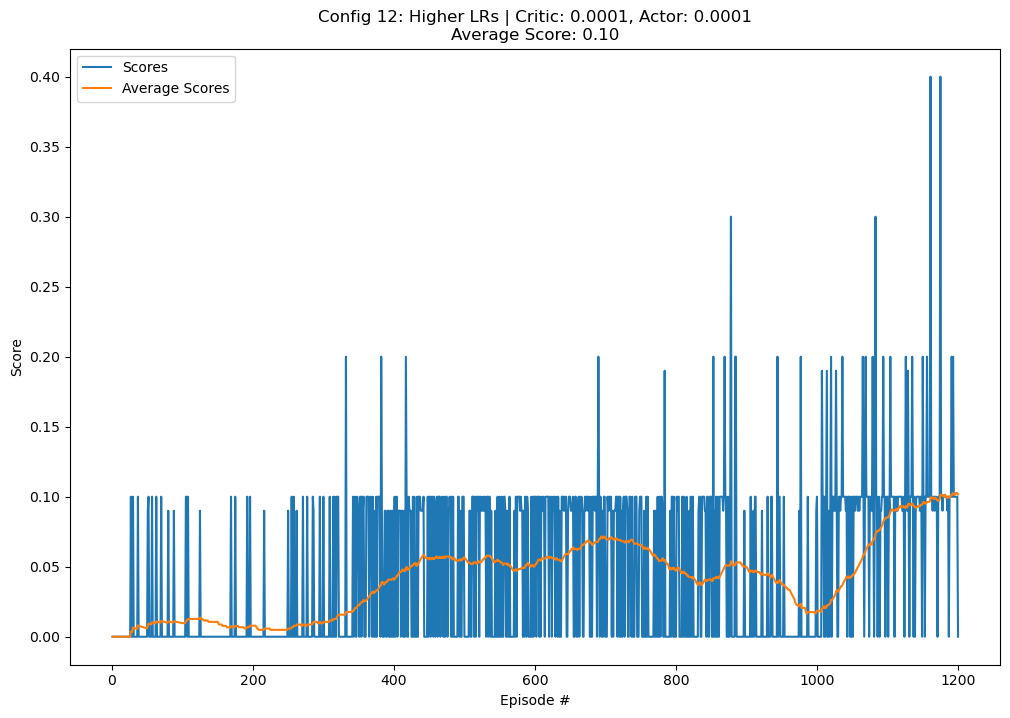

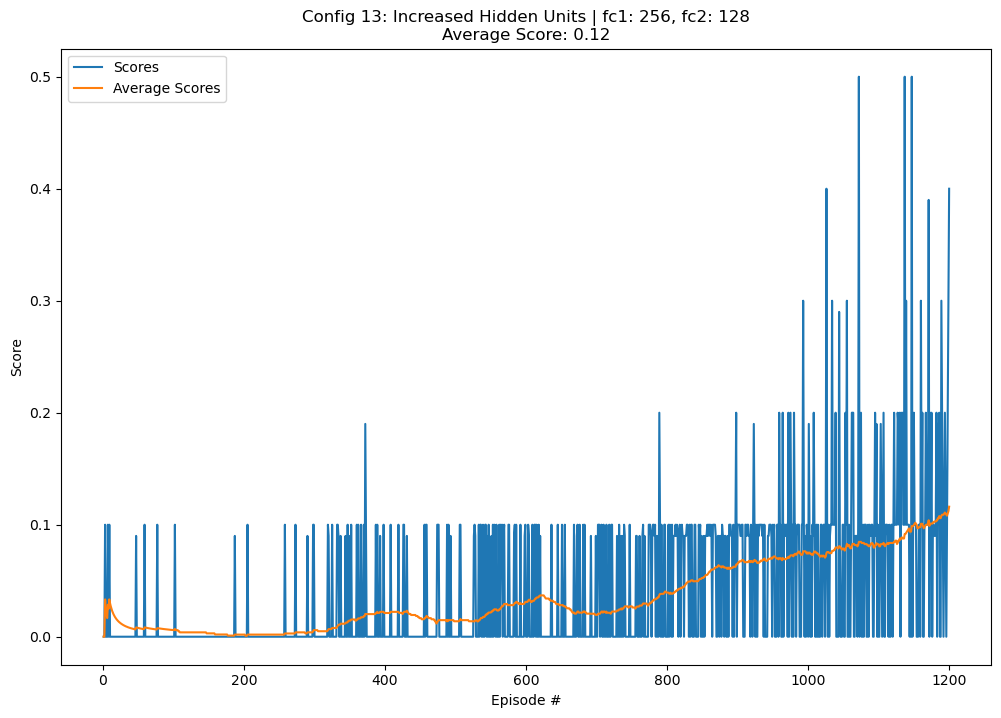

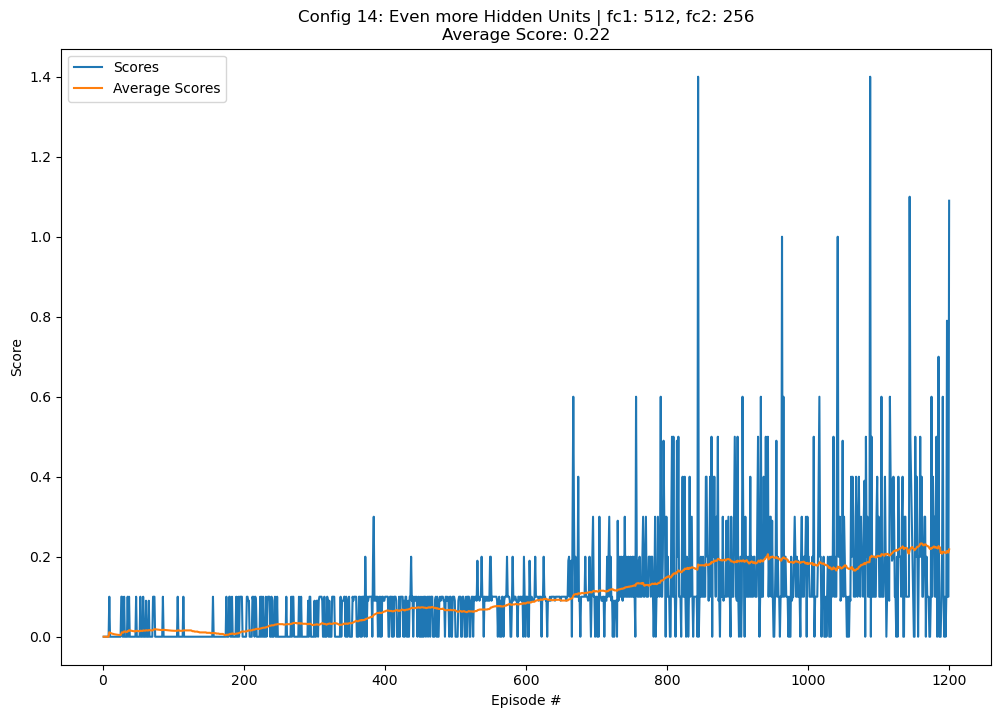

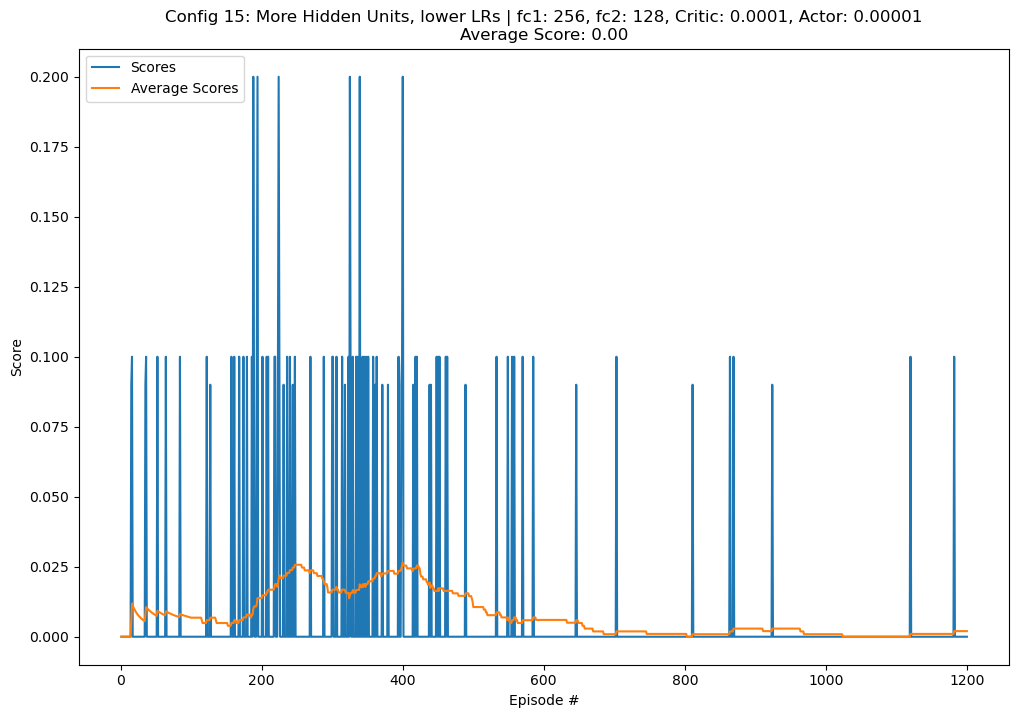

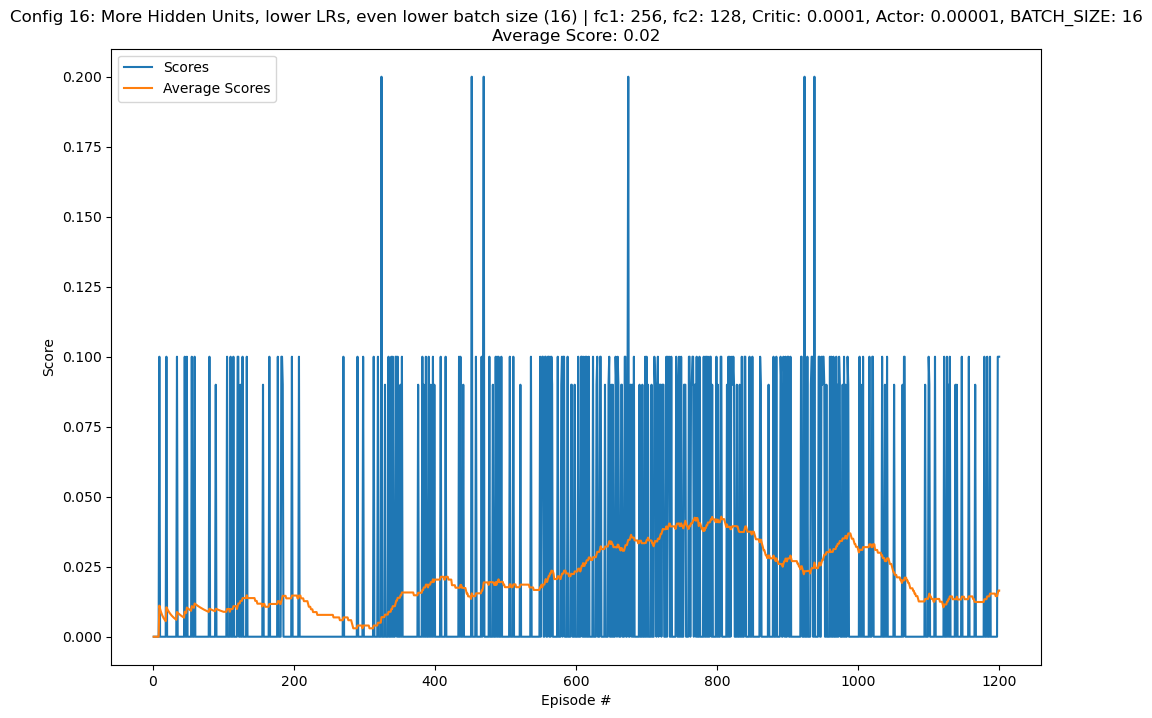

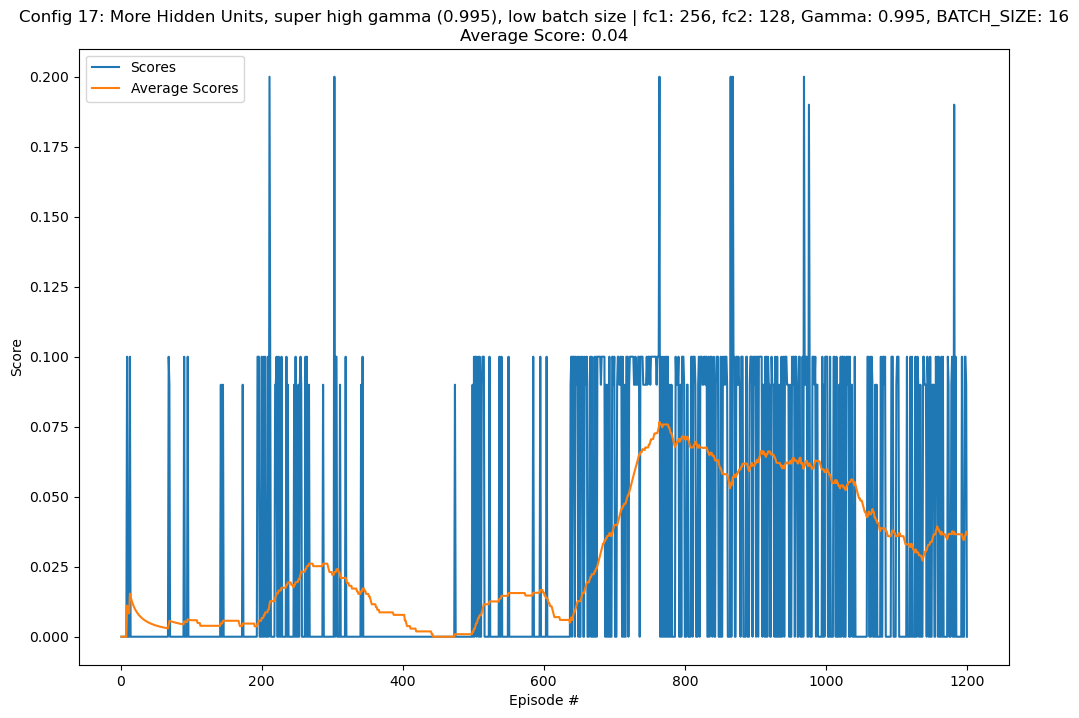

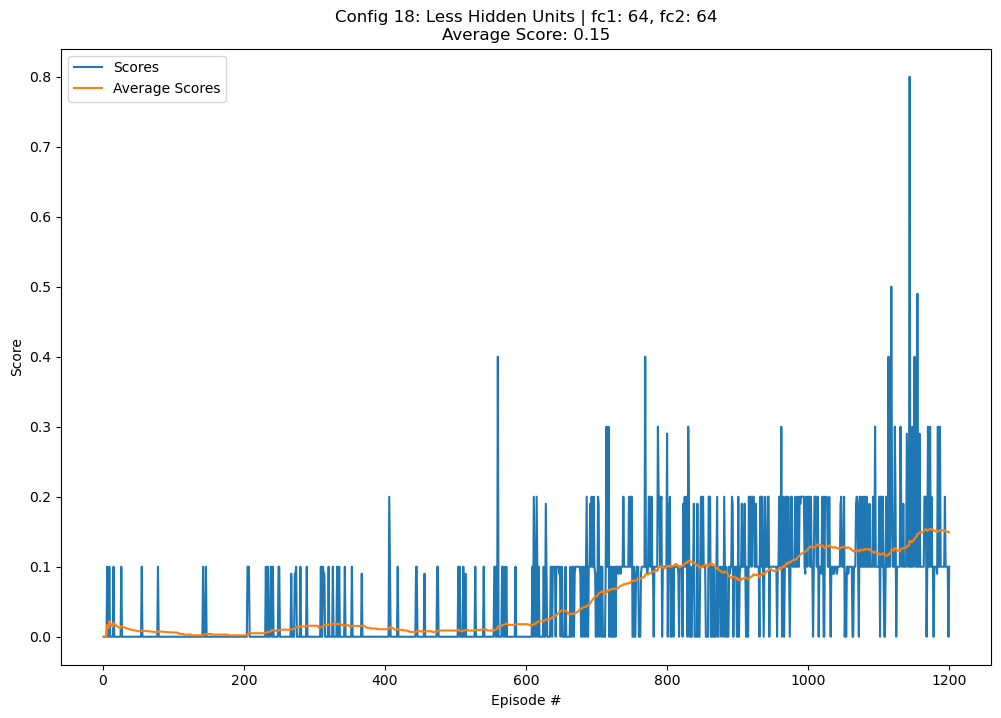

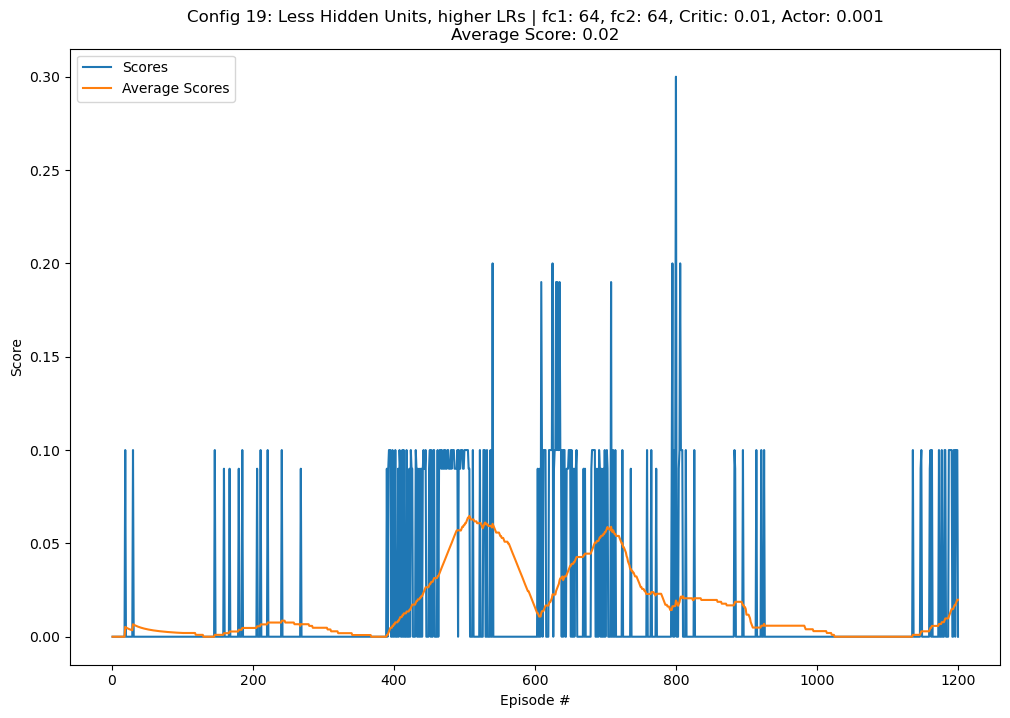

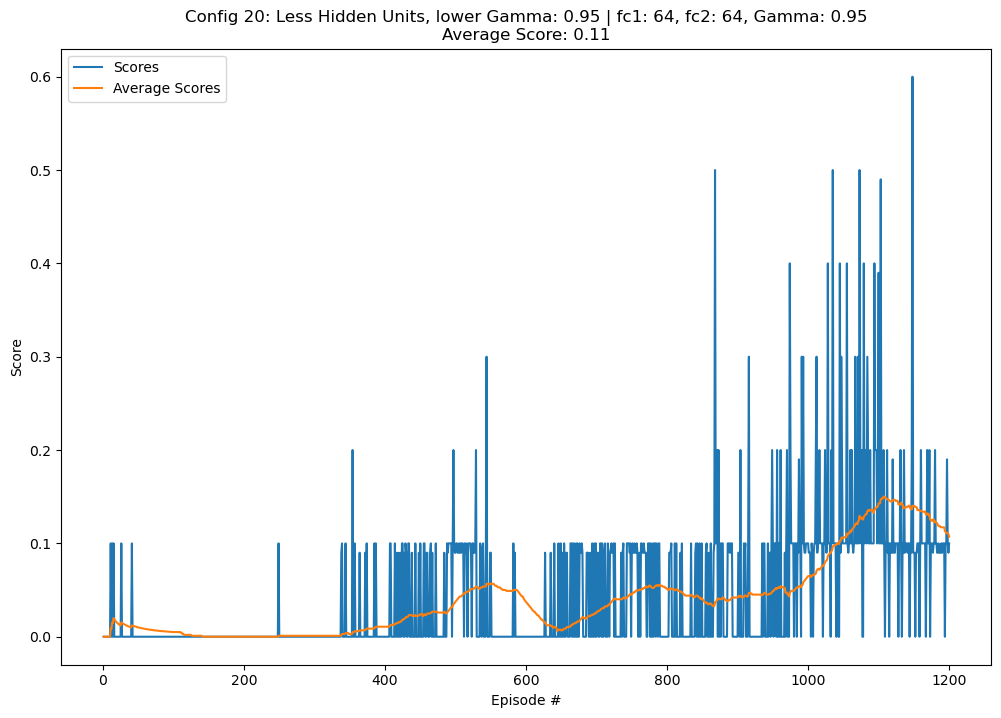

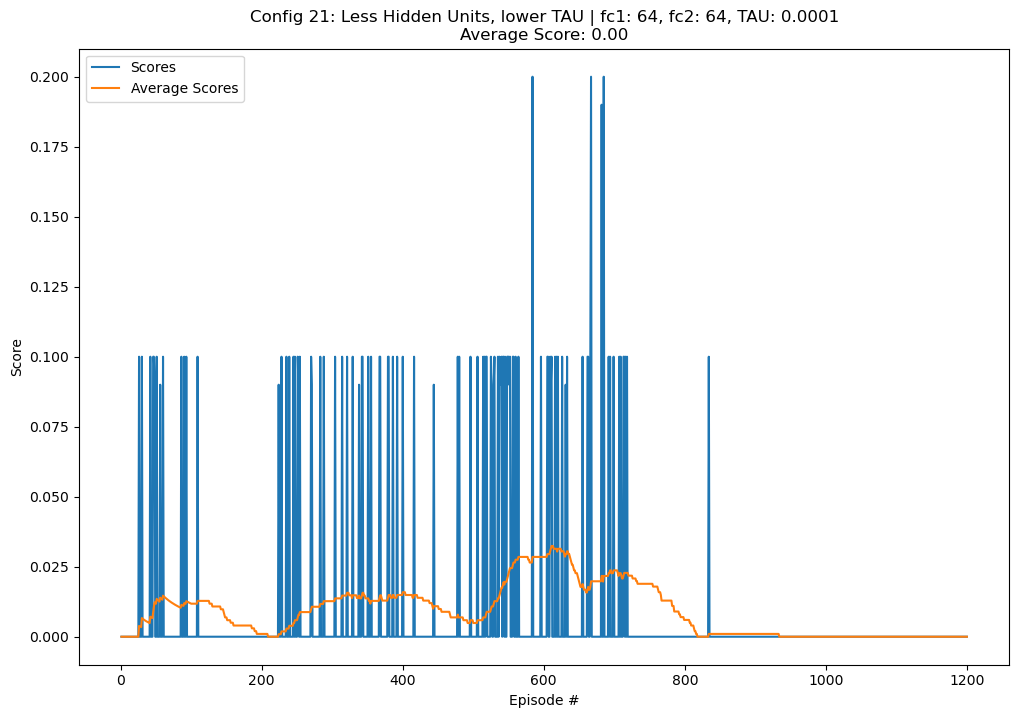

In [7]:
results = []

for idx, config in enumerate(configs):
    print(f"\nRunning configuration {idx + 1}/{len(configs)}: {config.description}")
    scores, avg_score_list = ddpg(config,n_episodes=1200)
    results.append((config, scores, avg_score_list))

fig, ax = plt.subplots(figsize=(12, 8))

for idx, (config, _, avg_scores) in enumerate(results):
    ax.plot(np.arange(1, len(avg_scores) + 1), avg_scores, label=f"Config {idx + 1}: {config.description}")

ax.set_ylabel('Average Score')
ax.set_xlabel('Episode #')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('DDPG Training Results for Different Configurations')
plt.show()

for idx, (config, scores, avg_scores) in enumerate(results):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(np.arange(1, len(scores) + 1), scores, label='Scores')
    ax.plot(np.arange(1, len(avg_scores) + 1), avg_scores, label='Average Scores')
    ax.set_ylabel('Score')
    ax.set_xlabel('Episode #')
    ax.legend(loc='upper left')
    plt.title(f"Config {idx + 1}: {config.description}\nAverage Score: {avg_scores[-1]:.2f}")
    plt.show()

### 4. And finally - the final Trainingrun

-> In the final run we use more units and a higher TAU.

Episode 1661	Average Score: 0.51	Score: 2.6005
Environment solved in 1661 episodes!
Episode 2000	Average Score: 0.74	Score: 1.6955

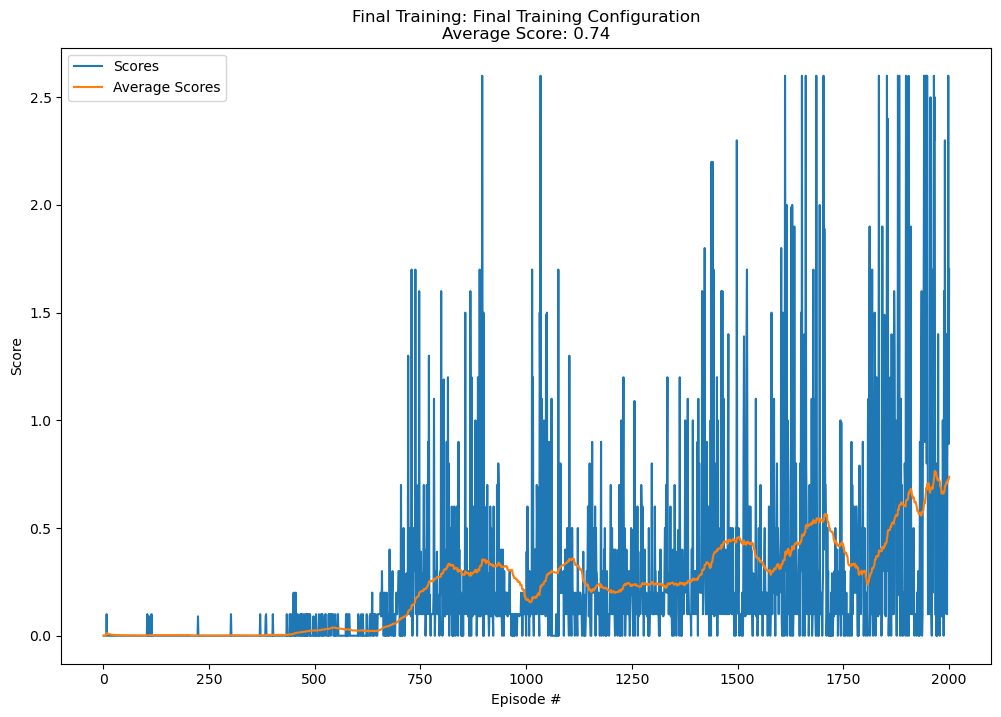

In [6]:
# Final Training Run
agent = 0

config_final = Config(description="Final Training Configuration", batch_size=128, lr_actor=1e-4, lr_critic=1e-3, tau=0.1, fc1=256, fc2=128, seed=0)

scores, avg_score_list = ddpg(config_final, n_episodes=2000)

# Plotting the final training results
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1, len(scores) + 1), scores, label='Scores')
ax.plot(np.arange(1, len(avg_score_list) + 1), avg_score_list, label='Average Scores')
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')

ax.legend(loc='upper left')
plt.title(f"Final Training: {config_final.description}\nAverage Score: {avg_score_list[-1]:.2f}")
plt.show()


In [10]:
env.close()